# 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install git+https://github.com/SKT-AI/KoBART#egg=kobart

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKT-AI/KoBART to /tmp/pip-install-sv_uufvx/kobart_85ab1274c61a4cafbb0abf2b89a1af8e
  Running command git clone -q https://github.com/SKT-AI/KoBART /tmp/pip-install-sv_uufvx/kobart_85ab1274c61a4cafbb0abf2b89a1af8e
     |████████████████████████████████| 132 kB 8.2 MB/s 
     |████████████████████████████████| 814 kB 55.7 MB/s 
     |████████████████████████████████| 776.8 MB 18 kB/s 
     |████████████████████████████████| 1.9 MB 49.0 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
     |████████████████████████████████| 140 kB 70.3 MB/s 
     |████████████████████████████████| 829 kB 63.3 MB/s 
     |████████████████████████████████| 880 kB 61.3 MB/s 
     |████████████████████████████████| 3.3 MB 57.5 MB/s 
     |████████████████████████████████| 1.1 MB 63.8 MB/s 
     |████████████████████████████████| 94 kB 4.7 MB/s 
     |██████████████████

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import os 
import gc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW

from tqdm import tqdm

In [6]:
data = pd.read_csv("/content/drive/MyDrive/KUBIG 썸네일 프로젝트/전처리코드/전처리_data(이모지 그대로).csv",index_col=0)
#data.drop(['channel_name','title','date','thumbnail','videoId','URL'],axis=1,inplace=True)

In [7]:
data.head()

,channel_name,title,date,thumbnail,videoId,URL,viewCount,likeCount,commentCount,subscriber,category,date_diff,title_symbol,noun,preprocessed_title,views_bin
0,피지컬갤러리,전직 UDT. 특수부대 학원에 가다! (숨참기 8분 30초 ㄷㄷ...?) | 달려라...,2019-11-23,https://i.ytimg.com/vi/tV1Dc-LCZJw/hqdefault.jpg,tV1Dc-LCZJw,https://www.youtube.com/watch?v=tV1Dc-LCZJw,11610712,62590.0,5187.0,3070000,스포츠_운동,911,9,7,전직 udt 특수부대 학원에 가다 ! 숨참기 8분 30초 ㄷㄷ ? 달려라 김계란 e...,700
1,피지컬갤러리,110만 유튜버 해외여행 클라스.. ㄷㄷ,2019-11-04,https://i.ytimg.com/vi/bPCriDPI4Oc/hqdefault.jpg,bPCriDPI4Oc,https://www.youtube.com/watch?v=bPCriDPI4Oc,8770917,54094.0,7249.0,3070000,스포츠_운동,93,2,3,110만 유튜버 해외여행 클라스 ㄷㄷ,700
2,피지컬갤러리,푸쉬업 '이렇게' 제발 하지마세요 (팔꿈치 박살),2019-01-20,https://i.ytimg.com/vi/DMU6bat46SM/hqdefault.jpg,DMU6bat46SM,https://www.youtube.com/watch?v=DMU6bat46SM,6101839,65041.0,3316.0,3070000,스포츠_운동,1218,4,4,푸쉬업 이렇게 제발 하지마세요 팔꿈치 박살,700
3,피지컬갤러리,북한 잠수함에 권총 한 자루를 들고간 UDT 작전 실화 (with 유병호 준위),2019-09-02,https://i.ytimg.com/vi/jXDlTaxnp6E/hqdefault.jpg,jXDlTaxnp6E,https://www.youtube.com/watch?v=jXDlTaxnp6E,5924894,59601.0,6539.0,3070000,스포츠_운동,993,2,9,북한 잠수함에 권총 한 자루를 들고간 udt 작전 실화 with 유병호 준위,700
4,피지컬갤러리,UDT vs 프로 파이터들 (달려라 김계란 Ep2 팀매드 체육관 인턴 1부),2019-09-28,https://i.ytimg.com/vi/lmJSbxXyom0/hqdefault.jpg,lmJSbxXyom0,https://www.youtube.com/watch?v=lmJSbxXyom0,5774965,39466.0,4191.0,3070000,스포츠_운동,967,2,9,udt vs 프로 파이터들 달려라 김계란 ep2 팀매드 체육관 인턴 1부,700


In [8]:
#data = data[data.category=='스포츠_운동']

In [9]:
num_col = data.drop(['preprocessed_title','views_bin'],axis=1)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
result = le.fit_transform(data['views_bin'])
data['views_bin'] = result

In [11]:
data.views_bin.value_counts() # 얘 범주형 변수로 안바꿔도 되나

3    11942
0    10933
1    10793
2    10608
4    10178
Name: views_bin, dtype: int64

In [12]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(data, test_size = 0.2, shuffle=True, random_state=34)
print(len(train_dataset))
print(len(test_dataset))

43563
10891


In [14]:
train_dataset, val_dataset  = train_test_split(train_dataset, test_size = 0.2, shuffle=True, random_state=34)
print(len(train_dataset))
print(len(val_dataset))

34850
8713


In [15]:
# dataloader에서 오류가 나서 인덱스 재설정
train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

In [16]:
train_dataset.preprocessed_title.iloc[37]

'🥃 라가불린26년 마셔봤습니다 ! ! 초 레어 위스키 8종 리뷰'

# Tokenization

In [17]:
 from transformers import BartModel
from kobart import get_pytorch_kobart_model, get_kobart_tokenizer

tokenizer = get_kobart_tokenizer()
# 표정 이모지 토큰 추가
tokenizer.add_tokens(['😬', '😋', '😌', '😍', '😘', '😗', '😙', '😚', '😜', '😝', '😛', '🤑', '😎', '🤗', '😏', '😶', '😐',  '😑', '😒', '🙄', '🤔', '😳', '😟', '😠', '😡', '😔', '😕', '🙁', '☹️', '☹️',
                             '😣', '😖', '😫', '😩', '😤', '😮', '😱', '😨', '😰', '😯', '😦', '😧', '😢', '😥', '😪', '😓', '😭', '😵', '😲', '🤐', '😷', '🤒', '🤕', '😴', '💤', '💩', '😈', '👿', '👹', '👺',
                             '💀', '👻', '👽', '🤖', '😺', '😸', '😹', '😻', '😼', '😽', '🙀', '😿', '😾'])

# 신체 부위 이모지 토큰 추가
tokenizer.add_tokens(['🙌', '👏', '👋', '👍', '👊', '✊', '✌️', '👌', '✋', '💪', '🙏', '☝️', '👆', '👇', '👈', '👉', '🖕', '🤘', '🖖', '✍️', '💅', '👄', '👅', '👂', '👃', '👁', '👀', '👤', '🗣'])              

# 사람, 가족 이모지 토큰 추가 (여러 명 있는 경우 분할 될 수 있음)
tokenizer.add_tokens(['💑', '👩‍❤️‍👩', '👨‍❤️‍👨', '💏', '👩‍❤️‍💋‍👩', '👨‍❤️‍💋‍👨', '👪', '👨‍👩‍👧', '👨‍👩‍👧‍👦', '👨‍👩‍👦‍👦', '👨‍👩‍👧‍👧', '👩‍👩‍👦', '👩‍👩‍👧', '👩‍👩‍👧‍👦', '👩‍👩‍👧‍👧', '👨‍👨‍👦', '👨‍👨‍👧', '👨‍👨‍👧‍👦', '👨‍👨‍👦‍👦', '👨‍👨‍👧‍👧', '👶', '👦', '👧', '👨', '👩', '👱', '👴', '👵', 
                             '👲', '👳', '👮', '👷', '💂', '🕵', '🎅', '👼', '👸', '👰', '🚶', '🏃', '💃', '👯', '👫', '👬', '👭', '🙇', '💁', '🙅', '🙆', '🙋', '🙎', '🙍', '💇', '💆'])

# 패션, 미용 이모지 토큰 추가
tokenizer.add_tokens(['👚', '👕', '👖', '👔', '👗', '👙', '👘', '💄', '💋', '👣', '👠', '👡', '👢', '👞', '👟', '👒', '🎩', '⛑', '🎓', '👑', '🎒', '👝', '👛', '👜', '💼', '👓', '🕶', '💍', '🌂'])


# 음식 이모지 토큰 추가
tokenizer.add_tokens(['🍏', '🍎', '🍐', '🍊', '🍋', '🍌', '🍉', '🍇', '🍓', '🍈', '🍒', '🍑', '🍍', '🍅', '🍆', '🌶', '🌽', '🍠', '🍯', '🍞', '🧀', '🍗', '🍖', '🍤', '🍳', '🍔', '🍟', '🌭', '🍕', '🍝', 
                             '🌮', '🌯', '🍜', '🍲', '🍥', '🍣', '🍱', '🍛', '🍙', '🍚', '🍘', '🍢', '🍡', '🍧', '🍨', '🍦', '🍰', '🎂', '🍮', '🍬', '🍭', '🍫', '🍿', '🍩', '🍪', '🍺', '🍻', '🍷', '🍸', '🍹', '🍾',
                             '🍶', '🍵', '☕️', '🍼', '🍴', '🍽'])

# 동물, 환경 이모지 토큰 추가
tokenizer.add_tokens(['🐶', '🐱','🐭','🐹', '🐰', '🐻', '🐼', '🐨', '🐯', '🦁', '🐮', '🐷', '🐽', '🐸', '🐙', '🐵', '🙈', '🙉', '🙊', '🐒', '🐔', '🐧', '🐦', '🐤', '🐣', '🐥', '🐺', '🐗', '🐴', '🦄', '🐝', 
                             '🐛', '🐌', '🐞', '🐜', '🕷', '🦂', '🦀', '🐍', '🐢', '🐠', '🐟', '🐡', '🐬', '🐳', '🐋', '🐊', '🐆', '🐅', '🐃', '🐂', '🐄', '🐪', '🐫', '🐘', '🐐', '🐎', '🐖', '🐀', '🐁', '🐏', '🐑',
                              '🐓', '🦃', '🕊', '🐕', '🐩', '🐈', '🐇', '🐿', '🐾', '🐉','🐲', '🌵', '🎄', '🌲', '🌳', '🌴', '🌱', '🌿', '☘', '🍀', '🎍', '🎋', '🍃', '🍂', '🍁', '🌾', '🌺', '🌻', '🌹', '🌷', '🌼', '🌸',
                              '💐', '🍄', '🌰', '🎃', '🐚', '🕸', '🌎', '🌍', '🌏', '🌕', '🌖', '🌗', '🌘', '🌑', '🌒', '🌓', '🌔', '🌚', '🌝', '🌛', '🌜', '🌞', '🌙', '⭐️', '🌟', '💫', '✨', '☄', '☀️', '🌤', '⛅️',
                              '🌥', '🌦', '☁️', '🌧', '⛈', '🌩', '⚡️', '🔥', '💥', '❄️', '🌨', '🔥', '💥', '❄️', '🌨', '☃️', '⛄️', '🌬', '💨' ,'🌪', '🌫', '☂️', '☔️', '💧', '💦', '🌊'])

# 스포츠, 취미활동 이모지 토큰 추가
tokenizer.add_tokens(['⚽️', '🏀', '🏈', '⚾️', '🎾', '🏐', '🏉', '🎱', '⛳️', '🏌', '🏓', '🏸', '🏒', '🏑', '🏏', '🎿', '⛷', '🏂', '⛸', '🏹', '🎣', '🚣', '🏊', '🏄', '🛀', '⛹', '🏋', '🚴', '🚵', '🏇', '🕴', '🏆',
                             '🎽', '🏅', '🎖', '🎗', '🏵', '🎫', '🎟', '🎭', '🎨', '🎪', '🎤', '🎧', '🎼', '🎹', '🎷', '🎺', '🎸', '🎻', '🎬', '🎮', '👾', '🎯', '🎲', '🎰', '🎳'])

# 여행 이모지 토큰 추가
tokenizer.add_tokens(['🚗', '🚕', '🚙', '🚌', '🚎', '🏎', '🚓', '🚑', '🚒', '🚐', '🚚', '🚛', '🏍', '🚲', '🚨', '🚔', '🚍', '🚘', '🚖', '🚡', '🚠', '🚟', '🚃', '🚋', '🚝', '🚄', '🚅', '🚈', '🚞', '🚂', '🚆', 
                             '🚇', '🚊', '🚉', '🚁', '🛩', '✈️', '🛫', '🛬', '⛵️', '🛥', '🚤', '⛴', '🛳', '🚀', '🛰', '💺', '⚓️', '🚧', '⛽️', '🚏', '🚦', '🚥', '🏁', '🚢', '🎡', '🎢', '🎠', '🏗', '🌁', '🗼', '🏭', '⛲️',
                             '🎑', '⛰', '🏔', '🗻', '🌋', '🗾', '🏕', '⛺️', '🏞', '🛣', '🛤', '🌅', '🌄', '🏜', '🏖', '🏝', '🌇', '🌆', '🏙', '🌃', '🌉', '🌌', '🌠', '🎇', '🎆', '🌈', '🏘', '🏰', '🏯', '🏟', '🗽', '🏠',
                             '🏡', '🏚', '🏢', '🏬', '🏣', '🏤', '🏥', '🏦', '🏨', '🏪', '🏫', '🏩', '💒', '🏛', '⛪️', '🕌', '🕍', '🕋', '⛩'])

# 사물 이모지 토큰 추가
tokenizer.add_tokens(['📱', '📲', '💻', '⌨', '🖥', '🖨', '🖱', '🖲', '🕹', '🗜', '💽', '💾', '💿', '📀', '📼', '📷', '📸', '📹', '🎥', '📽', '🎞', '📞', '📟', '📠', '📺', '📻', '🎙', '🎛', '⏲', '⏰', '🕰', '⏳', '⌛️',
                             '📡', '🔋', '🔌', '💡', '🔦', '🕯', '🗑', '🛢', '💸', '💵', '💴', '💶', '💷', '💰', '💳', '💎', '⚖', '🔧', '🔨', '⚒', '🛠', '⛏', '🔩', '⚙', '⛓', '🔫', '💣', '🔪', '🗡', '⚔', '🛡', '🚬', '☠', '⚰',
                             '⚱', '🏺', '🔮', '📿', '💈', '⚗', '🔭', '🔬', '🕳', '💊', '💉', '🌡', '🏷', '🔖', '🚽', '🚿', '🛁', '🔑', '🗝', '🛋', '🛌', '🛏', '🚪', '🛎', '🖼', '🗺', '⛱', '🗿', '🛍', '🎈', '🎏', '🎀', '🎁', '🎊',
                             '🎉', '🎎', '🎐', '🎌', '🏮', '✉️', '📩', '📨', '📧', '💌', '📮', '📪', '📫', '📬', '📭', '📦', '📯', '📥', '📤', '📜', '📃', '📑', '📊', '📈', '📉', '📄', '📅', '📆', '🗓', '📇', '🗃', '🗳',
                             '🗄', '📋', '🗒', '📁', '📂', '🗂', '🗞', '📰', '📓', '📕', '📗', '📘', '📙', '📔', '📒', '📚', '📖', '🔗', '📎', '🖇', '✂️', '📐', '📏', '📌', '📍', '🚩', '🏳', '🏴', '🔐', '🔒', '🔓', '🔏', '🖊',
                             '🖊', '🖋', '✒️', '📝', '✏️', '🖍', '🖌', '🔍', '🔎'])

# 감정, 심볼 이모지 토큰 추가 
tokenizer.add_tokens(['💛', '💙', '💜', '💔', '❣️', '💞', '💓', '💗', '💖', '💘', '💝', '💟', '☮', '✝️', '☪', '🕉', '☸', '✡️', '🔯', '🕎', '☯️', '☦', '🛐', '♈️', '♉️', '♊️', '♌️', '♍️', '🆔', '⚛', '☢', '☣', '📴',
                             '📳', '✴️', '🆚', '💮', '🅰️', '🅱️', '🆎', '🆑', '🅾️', '🆘', '⛔️', '📛', '🚫', '❌', '⭕️', '💢', '🚷', '🚯', '🚳', '🚱', '🔞', '📵', '❗️', '❕', '❓', '❔', '💯', '🔅', '🔆', '🔱', '⚜', '〽️',
                             '⚠️', '🚸', '🔰', '♻️', '💹', '❇️', '✳️', '❎', '✅', '💠', '🌀', '➿', '🌐', 'Ⓜ️', '🏧', '🛂', '🛃', '🛄', '🛅', '♿️', '🚭', '🚾', '🅿️', '🚰', '🚹', '🚺', '🚼', '🚻', '🚮', '🎦', '📶', '🈁',
                             '🆖', '🆗', '🆙', '🆒', '🆕', '🆓', '🔟', '🔢', '⏸', '⏯', '⏹', '⏺', '⏭', '⏮', '⏩', '⏪', '🔀', '🔁', '🔂', '🔼', '🔽', '⏫', '⏬', '➡️', '⬅️', '⬆️', '⬇️', '🔄', '↪️', '↩️', '⤴️',
                             '⤵️', 'ℹ️', '🔤', '🔡', '🔠', '🔣', '🎵', '🎶', '〰️', '➰', '🔃', '➕', '➖', '➗', '✖️', '💲', '💱', '™️', '🔚', '🔙', '🔛', '🔝', '🔜', '☑️', '🔘', '⚪️', '⚫️', '🔴', '🔵', '🔸', '🔹', '🔶',
                             '🔷', '🔺', '▫️', '⬛️', '⬜️', '🔻', '◼️', '◻️', '◾️', '◽️', '🔲', '🔳', '🔈', '🔉', '🔊', '🔇', '📣', '📢', '🔔', '🔕', '🃏', '🀄️', '🎴', '💭', '🗯', '💬', '🕐', '🕑', '🕒', '🕓', '🕔', '🕕', '🕖',
                             '🕗', '🕘', '🕙', '🕚', '🕛', '🕜', '🕝', '🕞', '🕟', '🕠', '🕡', '🕢', '🕣', '🕤', '🕥', '🕦', '🕧'])

model = BartModel.from_pretrained(get_pytorch_kobart_model())
inputs = tokenizer([train_dataset.preprocessed_title.iloc[37]], return_tensors='pt')
#model(inputs['input_ids'])

/content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip[██████████████████████████████████████████████████]
/content/.cache/kobart_base_cased_ff4bda5738.zip[██████████████████████████████████████████████████]


In [18]:
ex1 = tokenizer.encode(train_dataset.preprocessed_title.iloc[37])
tokenizer.convert_ids_to_tokens(ex1)

['▁',
 '<unk>',
 '▁라',
 '가',
 '불',
 '린',
 '2',
 '6년',
 '▁마',
 '셔',
 '봤',
 '습니다',
 '▁',
 '!',
 '▁',
 '!',
 '▁초',
 '▁레',
 '어',
 '▁위',
 '스키',
 '▁8',
 '종',
 '▁리',
 '뷰']

In [19]:
ex1 = tokenizer.encode(train_dataset.preprocessed_title.iloc[47])
tokenizer.convert_ids_to_tokens(ex1)

['▁주식',
 '초',
 '보',
 '자들',
 '▁3분',
 '안에',
 '▁스',
 '윙',
 '▁고',
 '수로',
 '▁만들어',
 '드립',
 '니다',
 '▁이거',
 '보면',
 '▁바로',
 '▁이해',
 '함',
 '▁',
 '!',
 '▁주식',
 '단',
 '테',
 '▁주식',
 '강의',
 '▁주식',
 '공',
 '부']

In [20]:
# train, val에 사용
class Train_Val_Dataset(Dataset):

    def __init__(self, df,max_seq_len=64):
        self.data = df
        self.tokenizer = get_kobart_tokenizer()
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):

        record = self.data.iloc[index]
        document, label = str(record["preprocessed_title"]), int(record["views_bin"])
        tokens = (
            [self.tokenizer.bos_token]
            + self.tokenizer.tokenize(document)
            + [self.tokenizer.eos_token]
        )
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                encoder_input_id += [self.tokenizer.pad_token_id]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[: self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id
            ]
            attention_mask = attention_mask[: self.max_seq_len]
        return {
            "input_ids": np.array(encoder_input_id, dtype=np.int_),
            "attention_mask": np.array(attention_mask, dtype=float),
            "labels": np.array(label, dtype=np.int_),
        }
    def __len__(self):
        return len(self.data)
    
# test 예측에 사용
class TestDataset(Dataset):

    def __init__(self, df,max_seq_len=64):
        self.data = df
        self.tokenizer = get_kobart_tokenizer()
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):

        record = self.data.iloc[index]
        document, label = str(record["preprocessed_title"]), int(record["views_bin"])
        tokens = (
            [self.tokenizer.bos_token]
            + self.tokenizer.tokenize(document)
            + [self.tokenizer.eos_token]
        )
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                encoder_input_id += [self.tokenizer.pad_token_id]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[: self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id
            ]
            attention_mask = attention_mask[: self.max_seq_len]
        return {
            "input_ids": np.array(encoder_input_id, dtype=np.int_),
            "attention_mask": np.array(attention_mask, dtype=float),
            "labels": np.array(label, dtype=np.int_),
        }


    def __len__(self):
        return len(self.data)

In [21]:
# 모델 하이퍼파라미터

NUM_EPOCHS = 3
L_RATE = 1e-5 
MAX_LEN = 64

TRAIN_BATCH_SIZE = 4 # batch size가 클수록 global minimum에 도달하는 속도가 증가합니다. (GPU 메모리에 따라 변경해 주세요, 너무 크면 OOM 문제가 발생합니다.)
TEST_BATCH_SIZE = 1

NUM_CORES = os.cpu_count() # Dataloader에 사용됩니다. 

NUM_CORES

2

In [22]:
train_data = Train_Val_Dataset(train_dataset)
val_data = Train_Val_Dataset(val_dataset)
test_data = TestDataset(test_dataset)

# batch_size 만큼 데이터 분할
train_dataloader = DataLoader(train_data,
                                batch_size=TRAIN_BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_CORES)

val_dataloader = DataLoader(val_data,
                            batch_size=TRAIN_BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_CORES)

test_dataloader = DataLoader(test_data,
                                batch_size=TEST_BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_CORES)



print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
8713
2179
10891


In [23]:
from transformers import BartForSequenceClassification
model = BartForSequenceClassification.from_pretrained(
    'gogamza/kobart-base-v2',
    num_labels = 5 ,
    # 출력 label의 개수
)
#for name,param in model.named_parameters():
#    if 'classifier' in name:
#        param.requires_grad = True
#    else :
#        param.requires_grad = False
# model을 device위에 올림
model.to(device)

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at gogamza/kobart-base-v2 and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.out_proj.weight', 'classification_head.dense.bias', 'classification_head.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BartForSequenceClassification(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768, padding_idx=3)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  

In [24]:
# optimizer 설정
optimizer = AdamW(model.parameters(),
              lr = L_RATE, 
              eps = 1e-8 
            )

In [25]:
PATH = "/content/drive/MyDrive/KUBIG/22-1_Project/modeling/" #모델 저장 경로

In [26]:
from sklearn.metrics import accuracy_score 

loss_fn = torch.nn.CrossEntropyLoss()

# loss값 저장
loss_values = []

# 학습 시작
for epoch in range(NUM_EPOCHS):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, NUM_EPOCHS))
    
    stacked_val_labels = []
    targets_list = []

    # ========================================
    #               Training
    # ========================================
    
    print('Training...')
    
    # train mode 변환
    model.train()
    # True로 설정하게 되면 해당 텐서에서 어떤 연산이 이루어졌는지 추적할 수 있고, 해당 텐서에 대한 그라디언트를 저장하게 됩니다. 
    torch.set_grad_enabled(True)


    # 1epoch마다 loss값 초기화
    total_train_loss = 0

    for i, batch in enumerate(tqdm(train_dataloader)):
        
        
        
        if i% 15000 == 0 :
          train_status = 'Batch ' + str(i) + ' of ' + str(len(train_dataloader))
          print(train_status, end='\r')


        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()        

        # 3개의 인풋
        outputs = model(b_input_ids, 
                    attention_mask=b_input_mask)
        
        # outputs tuple: (loss, logits)
        loss = loss_fn(outputs[0], b_labels)
        
        # loss는 텐서이기 때문에 숫자로 변환 후 더합니다. 
        total_train_loss = total_train_loss + loss.item()
        
        # backward()를 하기 전에 optimizer의 그라디언트를 0으로 합니다. 
        optimizer.zero_grad()
        
        # 그라디언트 계산
        loss.backward()
        
        
        # "exploding gradients" 문제를 예방해줍니다.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        
        # optimizer 가중치 업데이트
        optimizer.step() 
    
    print('Train loss:' ,total_train_loss)


    # ========================================
    #               Validation
    # ========================================
    
    print('\nValidation...')

    # evaluation mode로 변환
    model.eval()

    # validation 과정에서는 그라디언트를 연산하거나 저장하지 않습니다.(메모리, 진행 속도 세이브)
    torch.set_grad_enabled(False)
    
    total_val_loss = 0
    

    for j, batch in enumerate(tqdm(val_dataloader)):
        
        if i% 15000 == 0 :
          val_status = 'Batch ' + str(j) + ' of ' + str(len(val_dataloader))        
          print(val_status, end='\r')

        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)      


        outputs = model(b_input_ids, 
                attention_mask=b_input_mask)
        
        # 예측값
        preds = outputs[0]

        loss = loss_fn(preds, b_labels)
        total_val_loss = total_val_loss + loss.item()
        

        # 예측값을 CPU로 이동시킵니다. 
        val_preds = preds.detach().cpu().numpy()
        
        # labels을 cpu로 이동시킵니다.
        targets_np = b_labels.to('cpu').numpy()

        targets_list.extend(targets_np)

        if j == 0:  # 첫 번째 batch일 떄
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
        

    
    # validation accuracy 계산
    y_true = targets_list
    bert_y_pred = np.argmax(stacked_val_preds, axis=1)
    
    val_acc = accuracy_score(y_true, bert_y_pred)
    
    
    print('Val loss:' ,total_val_loss)
    print('Val acc: ', val_acc)


    # 모델 저장
    np.save(PATH+'epoch:{}_val_pred'.format(epoch),bert_y_pred)
    #torch.save(model.state_dict(), PATH+'epoch:{}_model.pt'.format(epoch))
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
               }, PATH+'epoch:{}_model.pt'.format(epoch))
    
    # 메모리 관리
    gc.collect()


======== Epoch 1 / 3 ========
Training...


  0%|          | 0/8713 [00:00<?, ?it/s]

100%|██████████| 8713/8713 [17:17<00:00,  8.40it/s]


Train loss: 12331.100558832288

Validation...


100%|██████████| 2179/2179 [00:58<00:00, 37.36it/s]


Val loss: 2825.743960082531
Val acc:  0.44554114541489725

======== Epoch 2 / 3 ========
Training...


  0%|          | 0/8713 [00:00<?, ?it/s]

100%|██████████| 8713/8713 [17:19<00:00,  8.38it/s]


Train loss: 10301.296036995947

Validation...


100%|██████████| 2179/2179 [00:58<00:00, 37.38it/s]


Val loss: 2818.5979492664337
Val acc:  0.48846551130494664

======== Epoch 3 / 3 ========
Training...


  0%|          | 0/8713 [00:00<?, ?it/s]

100%|██████████| 8713/8713 [17:16<00:00,  8.40it/s]


Train loss: 8474.49456743151

Validation...


100%|██████████| 2179/2179 [00:58<00:00, 37.16it/s]


Val loss: 3025.3693430973217
Val acc:  0.5063697922644325


In [27]:
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [28]:
# test 시작
checkpoint = torch.load(PATH+'epoch:2_model.pt',map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

for j, batch in enumerate(tqdm(test_dataloader)):
        
        if j % 10000 == 0 :
            inference_status = 'Batch ' + str(j+1) + ' of ' + str(len(test_dataloader))
        
            print(inference_status, end='\r')

        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)

        outputs = model(b_input_ids, 
                attention_mask=b_input_mask)
        
        # 예측값
        preds = outputs[0]
        preds = preds.detach().cpu().numpy()

        
        if j == 0:  
            stacked_preds = preds

        else:
            stacked_preds = np.vstack((stacked_preds, preds))

  0%|          | 6/10891 [00:00<06:30, 27.89it/s]

 92%|█████████▏| 10007/10891 [03:35<00:17, 49.37it/s]

100%|██████████| 10891/10891 [03:53<00:00, 46.56it/s]


In [29]:
# argmax로 label결정
preds = np.argmax(stacked_preds, axis=1)

preds

array([3, 3, 1, ..., 4, 1, 2])

In [30]:
pd.DataFrame(preds).value_counts()

2    2528
4    2527
3    2161
1    2062
0    1613
dtype: int64

In [31]:
preds[1:100]

array([3, 1, 4, 1, 2, 0, 1, 3, 1, 2, 4, 2, 4, 4, 4, 2, 3, 2, 1, 2, 4, 1,
       1, 2, 2, 4, 0, 3, 4, 0, 1, 3, 2, 1, 2, 0, 0, 1, 0, 2, 0, 2, 4, 2,
       2, 2, 2, 1, 2, 0, 1, 3, 3, 0, 2, 1, 0, 1, 0, 1, 1, 4, 3, 2, 1, 4,
       4, 4, 0, 2, 4, 3, 3, 4, 4, 3, 4, 4, 0, 3, 1, 2, 1, 4, 0, 2, 2, 3,
       4, 0, 2, 0, 0, 3, 4, 0, 3, 3, 0])

In [32]:
preds_tab = pd.DataFrame({'answer':test_dataset['views_bin'],'preds':preds})

In [33]:
# Accuracy 
(preds_tab['answer']==preds_tab['preds']).sum()/preds_tab.shape[0]

0.5175833256817556

# Modeling

In [ ]:
#!pip install transformers -i https://pypi.python.org/simple

Looking in indexes: https://pypi.python.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


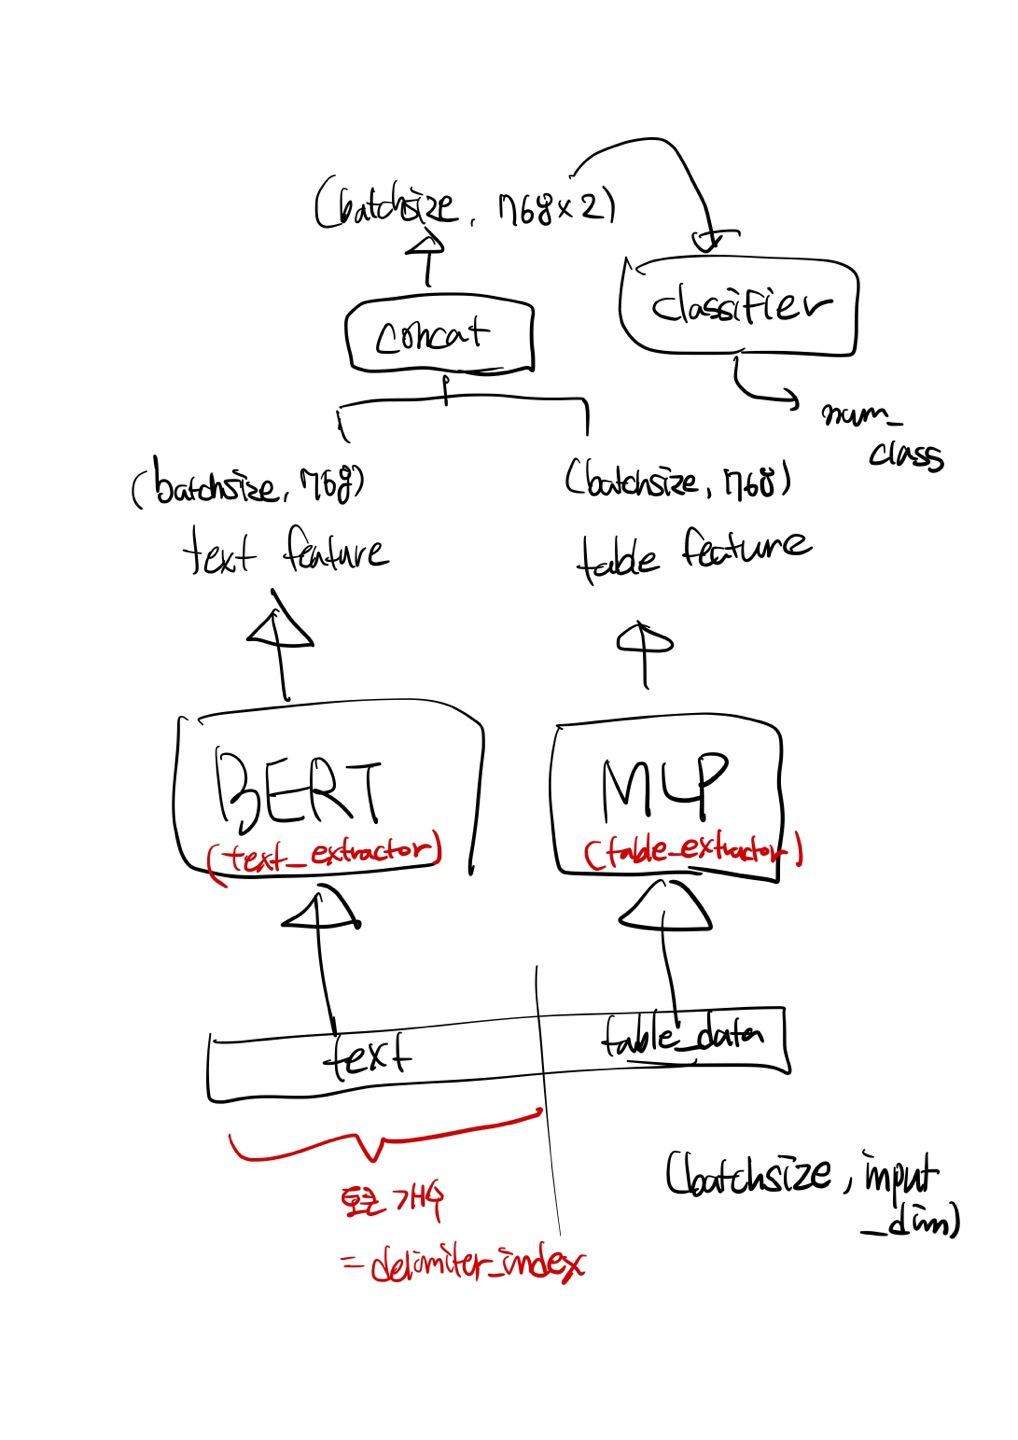

In [ ]:
import torch.nn as nn
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BartForSequenceClassification

In [ ]:
model = BartModel.from_pretrained(get_pytorch_kobart_model())
bart = model
print(model)

In [ ]:
text_input = train_data.__getitem__(100)
#model(torch.tensor(list(text_input)))

In [ ]:
dataiter = iter(train_dataloader)
batch = dataiter.next()
#outs = model(input_ids = batch["input_ids"], attention_mask=batch["attention_mask"],labels=batch['labels'])
outs = model(input_ids = batch["input_ids"], attention_mask=batch["attention_mask"])

#input

In [ ]:
batch

{'attention_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         

In [ ]:
#iter(train_dataloader).next().shape

AttributeError: ignored

In [ ]:
outs.keys()

odict_keys(['last_hidden_state', 'past_key_values', 'encoder_last_hidden_state'])

In [ ]:
outs['last_hidden_state'].shape

torch.Size([4, 64, 768])

In [ ]:
hidden_states = outs['last_hidden_state']
hidden_states = hidden_states.view(hidden_states.size(0),-1,hidden_states.size(-1))[
            :, -1, :
        ]#.shape # classification의 head
        # eos token은 없는걸로~,,
hidden_states.shape

torch.Size([4, 768])

In [ ]:
num_col = train_dataset.drop(['preprocessed_title','views_bin'],axis=1).iloc[:4] # 정형데이터

In [ ]:
num_col.shape

(4, 8)

In [ ]:
torch.cat([hidden_states])

In [ ]:
model(text_input)

Seq2SeqModelOutput([('last_hidden_state',
                     tensor([[[ 1.9137,  1.8432,  0.4611,  ..., -0.7548, -0.7889,  0.1443],
                              [ 1.7813,  1.6042,  0.3111,  ..., -0.8072, -0.7477, -0.0823],
                              [ 1.9427,  1.7773,  0.3801,  ..., -0.7458, -0.7580,  0.0372]],
                     
                             [[-0.1405, -0.3270,  1.2497,  ...,  3.3635, -0.1150,  4.0974],
                              [ 0.2275, -1.7013,  1.9332,  ...,  3.8799,  0.5543,  3.2685],
                              [-0.4396, -1.9356,  1.7958,  ...,  3.8406,  1.4158,  2.9740]]],
                            grad_fn=<NativeLayerNormBackward>)),
                    ('past_key_values',
                     ((tensor([[[[-0.0980, -0.6658, -1.8089,  ...,  0.9602, -0.1882, -1.3252],
                                 [-0.7285, -1.6266, -1.5483,  ...,  0.2770, -0.2319, -1.4786],
                                 [ 0.3576, -0.2554,  0.0380,  ..., -0.2447,  0.7534, -

In [ ]:
#a = model(text_input)['last_hidden_state']
#linear = nn.Linear(in_features=768, out_features=768, bias=True)
#dropout = nn.Dropout(p=0.1, inplace=False)
#a = linear(a)
#a = dropout(a)
#print(a.shape)
#lin2 = nn.Linear(in_features=768, out_features=5, bias=True)
#a = lin2(a)
#print(a.shape)

torch.Size([2, 3, 768])
torch.Size([2, 3, 5])


In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim): # input_dim
        super(Classifier, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Sequential(nn.Linear(input_dim, input_dim//2),
                                    nn.ReLU(),
                                    nn.Linear(input_dim//2, input_dim//4),
                                    nn.ReLU(),
                                    nn.Linear(input_dim//4, output_dim))
    def forward(self, x):
        output = self.linear(x)
        return output

In [ ]:
class FinalModel(nn.Module):
    def __init__(self, delimiter_index, input_dim, num_label):  # text가 정수 인코딩 후, 정형데이터와 concat되어 tensor로 들어온다고 가정-> (batch, input_dim), delimiter는 이를 구분해주는 index라고 생각하면 됨.
                                                                            # (즉 0~delimiter-1 인덱스까지만 text 토큰들임.delimiter_index = text 토큰의 개수)
        super(FinalModel, self).__init__()
        self.text_extractor = bart 
        self.table_extractor = nn.Sequential(nn.Linear(input_dim-delimiter_index, 768//2),
                                             nn.ReLU(),
                                             nn.Linear(768//2, 768),
                                             nn.ReLU())
        self.classifier = Classifier(768 * 2, num_label)
    
    def forward(self, x):
        text_input = x[:, :delimiter_index] # (batch_size, delimiter_index)
        text_input = text_input.long() # bert는 long type의 데이터만 받을 수 있음
        table_input = x[:, delimiter_index:] # (batch_size, input_dim - delimiter_index)
        text_feature = self.text_extractor(text_input)[1] # (batch_size, 768)
        #print(text_feature)
        text_feature = list(text_feature)
        table_feature = self.table_extractor(table_input) # (batch_size, 768)
        fusion_input = torch.cat([text_feature, table_feature], dim = 1) # (batch_size, 768 * 2)
        output = self.classifier(fusion_input)
        return output



In [ ]:
# 예시 샘플
#tensor1 = torch.tensor([[1, 2, 3, 0.6], [2, 3, 4, 0.8]]) 

In [ ]:
type(tensor1)

torch.Tensor

In [ ]:
delimiter_index = 768
input_dim = 4
num_label = 5

In [ ]:
model = FinalModel(delimiter_index, input_dim, num_label)